# Data analysis using singular value decomposition (SVD) and co-occurrence matrices
In this notebook I'm showing how to analyse a 75k image dataset (crawled from unsplash.com) by using singular value decomposition (SVD) and co-occurrence matrices on the image labels.

In [1]:
import collections
import numpy as np
import scipy.sparse
import scipy.linalg
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import pickle
import imageio

In [2]:
with open('./metadata.pickle', 'rb') as f:
    metadata = pickle.load(f)

The dataset contains about 75,000 images, each with multiple associated labels.

In [3]:
print(len(metadata.keys()))
metadata['QSzdNJvF-Ak'] # the keys are image ids

75559


{'high_conf_tags': {'electric',
  'guitar',
  'guitarist',
  'male',
  'man',
  'music',
  'musician',
  'performance',
  'performer',
  'person'},
 'low_conf_tags': {'instrument', 'jazz', 'west-jakarta%2C-indonesia'},
 'featured_in_collections': {'1301616', '1458283', '2457190'},
 'available_variants': ['', '_LL', '_RR', '_L', '_R']}

In [4]:
# clean up metadata and merge high and low confidence tags
images = list(metadata.keys())
tags = [metadata[i]['high_conf_tags'] | metadata[i]['low_conf_tags'] for i in images]
all_tags = [item for sublist in tags for item in sublist]
unique_tags = set(all_tags)

len(all_tags), len(unique_tags)

(1324616, 73890)

only use tags with more that 20 occurrences:

In [5]:
counter = collections.Counter(all_tags)
selected_tags = list(map(lambda x: x[0], filter(lambda x: x[1]>20, counter.most_common())))
print(selected_tags[:10])

['woman', 'cloud', 'light', 'building', 'forest', 'blue', 'wallpaper', 'man', 'nature', 'girl']


## Creating an occurrence matrix

The occurrence matrix is a sparse binary matrix of dimensions (number of unique tags)x(number of images) and associates each image with its tags. 'lil_matrix' is the most efficient matrix type for iteratively creating a sparse matrix.

In [6]:
occurrence_matrix = scipy.sparse.lil_matrix((len(selected_tags), len(tags[:10000])))

Enter all occurrences into the occurrence matrix

In [7]:
%%time

def get_indices(t):
    return np.array([selected_tags.index(v) for v in t if v in selected_tags], dtype=np.int)

for i, image_tags in enumerate(tqdm(tags[:10000])):
    occurrence_matrix[get_indices(image_tags), i] = True

/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:



CPU times: user 6.13 s, sys: 68.1 ms, total: 6.19 s
Wall time: 6.13 s


Show the occurrences of the 2000 most common tags for a random selection of 100 images.
Images are on the x-axis, tags are on the y-axis where more common tags are at the top.

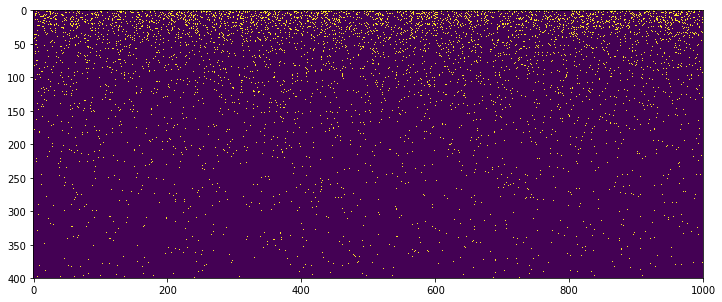

In [8]:
plt.figure(figsize=(12, 12))
plt.imshow(occurrence_matrix[:400, :1000].toarray())
plt.show()

## Creating the co-occurrence matrix

In [9]:
# convert the lil_matrix to a csr_matrix since they are more efficient for arithmetic ops
occurrence_matrix = scipy.sparse.csr_matrix(occurrence_matrix)
co_occurrence_matrix = occurrence_matrix * occurrence_matrix.T
co_occurrence_matrix.shape

(4204, 4204)

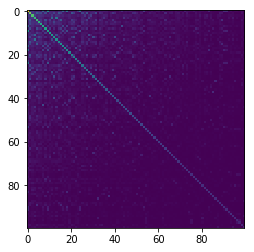

In [10]:
plt.imshow(co_occurrence_matrix[:100, :100].toarray())

## Clustering related tags using the co-occurrence matrix

In [11]:
for k in range(0, 2000, 130):
    d = np.array(selected_tags)[np.argsort(co_occurrence_matrix[k].toarray()[0])[::-1][:6]]
    print("{}{:<20}{}".format('Related tags to: ', str(selected_tags[k]), str(d)))

Related tags to: woman               ['woman' 'girl' 'female' 'portrait' 'man' 'person']
Related tags to: boat                ['boat' 'sea' 'water' 'blue' 'ocean' 'lake']
Related tags to: brunette            ['brunette' 'woman' 'girl' 'female' 'portrait' 'person']
Related tags to: flat-lay            ['flat-lay' 'white' 'food' 'flatlay' 'flower' 'table']
Related tags to: black-background    ['black-background' 'black' 'light' 'dark' 'wallpaper' 'black-and-white']
Related tags to: halloween           ['halloween' 'dark' 'autumn' 'fall' 'pumpkin' 'orange']
Related tags to: beer                ['beer' 'drink' 'food' 'alcohol' 'glass' 'bar']
Related tags to: lightbulb           ['lightbulb' 'light' 'bulb' 'wallpaper' 'glow' 'lamp']
Related tags to: reptile             ['reptile' 'animal' 'green' 'wildlife' 'lizard' 'snake']
Related tags to: parked              ['parked' 'car' 'road' 'street' 'building' 'travel']
Related tags to: one                 ['one' 'woman' 'flower' 'person' 'girl' '

In [12]:
for k in range(0, 1800, 220):
    d = np.array(selected_tags)[np.argsort(co_occurrence_matrix[k].toarray()[0])[:5]]
    print("{}{:<16}{}".format('Maximally *unrelated* tags to: ', str(selected_tags[k]), str(d)))

Maximally *unrelated* tags to: woman           ['paint-brush' 'cage' 'fujifeed' 'fight' 'wooden-door']
Maximally *unrelated* tags to: mountain-range  ['noir' 'grocery' 'moscow' 'penguin' 'modern-art']
Maximally *unrelated* tags to: warm            ['noir' 'chess' 'reflective' 'lips' 'cosmo']
Maximally *unrelated* tags to: bulb            ['noir' 'chess' 'reflective' 'lips' 'cosmo']
Maximally *unrelated* tags to: greenhouse      ['noir' 'cowboy' 'guitarist' 'prey' 'praise']
Maximally *unrelated* tags to: looking-away    ['noir' 'cowboy' 'guitarist' 'prey' 'praise']
Maximally *unrelated* tags to: florida         ['noir' 'prey' 'praise' 'imagine' 'chess']
Maximally *unrelated* tags to: cattle          ['noir' 'reflective' 'lips' 'cosmo' 'eye-contact']
Maximally *unrelated* tags to: rain-drop       ['noir' 'reflective' 'lips' 'cosmo' 'eye-contact']


## Finding similar images (based on labels) using singular value decomposition

In [13]:
%%time
U, s, Vh = scipy.linalg.svd(occurrence_matrix.toarray(), full_matrices=False)
U.shape, s.shape, Vh.shape

CPU times: user 3min 8s, sys: 1.16 s, total: 3min 9s
Wall time: 48 s


![svd](svd.png)

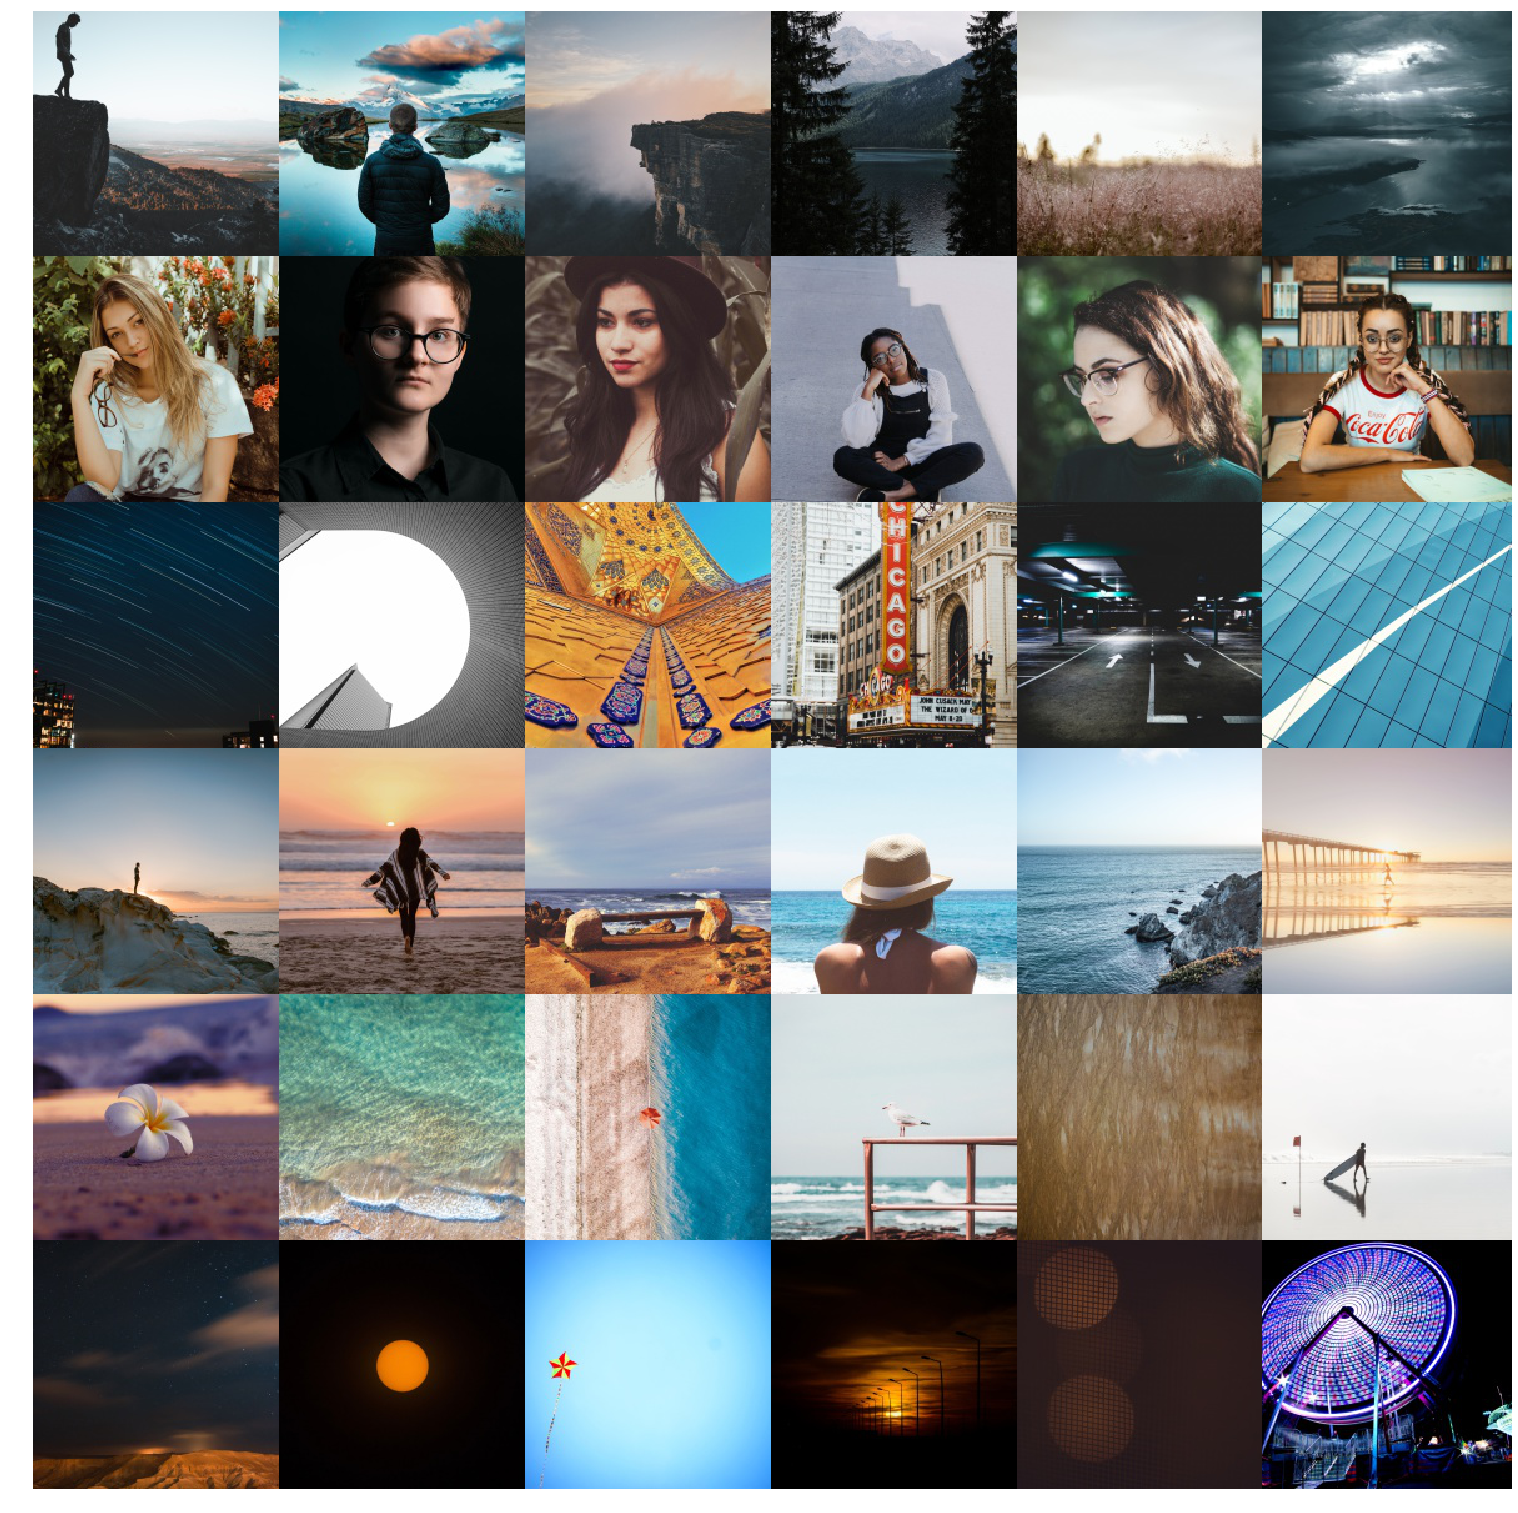

In [14]:
rows = 6
cols = 6

plot = plt.figure(figsize=(20, 20))
m = 1
for k in range(rows):
    r = np.array(images)[np.argsort(Vh[k])[:cols]]
    for q in r:

        img = imageio.imread(f'/home/dominik/Datasets/Unsplash/datasets/squarecrop-200px/images/{q}.jpg')
        plt.subplot(rows, cols, m)
        m += 1
        plt.imshow(img)
        plt.axis('off')
        
plt.tight_layout(pad=-3.5)
plt.show()
plt.close()

Each row above ↑ contains similar images according to the SVD. This is *not* a computer vision based approach but rather solely based on the similarity of image labels.